# Assignment 2A

**Name:** Nabilah Anuwar

**Student ID:** 31282016

In [94]:
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col
import pyspark.sql.functions as F
import numpy as np

# 1. Data Loading, Cleaning, Labelling, and Exploration (45%)

## 1.1 Data Loading

In [2]:
from pyspark import SparkConf
master = "local[*]"
app_name = "31282016 Assignment 2A"
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder.config(conf = spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [3]:
flightsRawDf = spark.read.csv("flight-delays/flight*.csv", header = True, inferSchema = True)

In [4]:
allColumnFlights = flightsRawDf.count()

## 1.2 Data Cleaning

### Part 1

In [5]:
schema1 = StructType([
    StructField("column_name", StringType()),
    StructField("no_of_row", IntegerType()),
    StructField("missing_percentage", FloatType())
])

def calc_miss(df, schema):
    col_name = df.columns
    total_col = df.count()
    result = []
    # https://www.datasciencemadesimple.com/count-of-missing-nanna-and-null-values-in-pyspark/
    total_miss = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0]
    
    for c in col_name:
        a_row = [c, total_miss[c], round((total_miss[c]/total_col)*100,2)]
        result.append(a_row)
        
    the_df = spark.createDataFrame(result, schema = schema).orderBy(col("missing_percentage").desc(), col("no_of_row").desc())
    return the_df

In [6]:
calc_miss(flightsRawDf, schema1).show(len(flightsRawDf.columns))

+-------------------+---------+------------------+
|        column_name|no_of_row|missing_percentage|
+-------------------+---------+------------------+
|CANCELLATION_REASON|   573213|             98.46|
|      AIRLINE_DELAY|   475831|             81.73|
|LATE_AIRCRAFT_DELAY|   475831|             81.73|
|      WEATHER_DELAY|   475831|             81.73|
|   AIR_SYSTEM_DELAY|   475831|             81.73|
|     SECURITY_DELAY|   475831|             81.73|
|       ELAPSED_TIME|    10455|               1.8|
|      ARRIVAL_DELAY|    10455|               1.8|
|           AIR_TIME|    10455|               1.8|
|            TAXI_IN|     9257|              1.59|
|       ARRIVAL_TIME|     9257|              1.59|
|          WHEELS_ON|     9257|              1.59|
|           TAXI_OUT|     8891|              1.53|
|         WHEELS_OFF|     8891|              1.53|
|    DEPARTURE_DELAY|     8633|              1.48|
|     DEPARTURE_TIME|     8633|              1.48|
|        TAIL_NUMBER|     1462|

#### CANCELLATION_REASON

This would require the flight to be cancelled. If it is not then it wouldn't be filled. This can be checked below.

In [7]:
flightsRawDf.select("CANCELLED").filter(col("CANCELLED")==0).count()

573213

The number above matched on why there are empty rows in the `CANCELLATION_REASON` as the flights listed here isn't cancelled.

#### AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY, AIR_SYSTEM_DELAY, SECURITY_DELAY

Seems to be empty simultaneously. They are columns based on input not calculations. Thus we can say they are missing due to human error.

#### ELAPSED_TIME

`ELAPSED_TIME` have a dependency on `AIR_TIME`, thus if `AIR_TIME` is missing it is possible that this will cause nulls.

#### ARRIVAL_DELAY

This column have a dependency on `ARRIVAL_TIME` and `SCHEDULED_ARRIVAL`, thus null `ARRIVAL_TIME` can cause nulls in this column

#### AIR_TIME

Though not on calculation based, the information is still based on `WHEELS_ON` and `WHEELS_OFF` thus having nulls in these columns can result in nulls in `AIR_TIME`

#### TAXI_IN, ARRIVAL_TIME, WHEELS_ON

`ARRIVAL_TIME` have dependencies on the other two. If there are nulls in these columns the resulting output will most likely be null. There are equal amount of nulls here which means the missing row does not have any information on any of these columns.

#### TAXI_OUT, WHEELS_OFF

Though not a calculated column, `TAXI_OUT` still depends on `WHEELS_OFF` column. Time duration elapsed between departure cannot be calculated without `WHEELS_OFF` time.

#### DEPARTURE_DELAY, DEPARTURE_TIME

Without `DEPARTURE_TIME`, `DEPARTURE_DELAY` cannot be calculated, again, even though it is not a calculated column.

#### TAIL_NUMBER

This column could be missing at random as it fully depend on human input. 

### Part 2

In [8]:
x = 10

def find_removed_columns(x, flightsRawDf):
    data = calc_miss(flightsRawDf, schema1)
    filtered = data.filter(col("missing_percentage") > x).select("column_name").collect()
    removedColumns = [str(row['column_name']) for row in filtered]
    return removedColumns

In [9]:
def eliminate_columns(removedColumns, flightsRawDf):
    flightsRawDf = flightsRawDf.drop(*[str(x) for x in removedColumns])
    return flightsRawDf

In [10]:
q122 = eliminate_columns(find_removed_columns(x, flightsRawDf), flightsRawDf)
print(f"The number of columns are {len(q122.columns)}")
print(f"The number of rows are {q122.count()}")

The number of columns are 25
The number of rows are 582184


In [11]:
flightsDf = q122.na.drop("any")
print(f"The number of columns are {len(flightsDf.columns)}")
print(f"The number of rows are {flightsDf.count()}")

The number of columns are 25
The number of rows are 571729


## 1.3 Data Labelling

### Part 1

In [12]:
flightsDf = flightsDf.withColumn("binaryArrDelay", when(col("ARRIVAL_DELAY")> 0,1).otherwise(0)).withColumn("binaryDeptDelay", when(col("DEPARTURE_DELAY")>0,1).otherwise(0))

Here we classify:

* negative values or less than 5 as *early* or 0

* the value between 5 and 20 (inclusive) as *on time* or 1

* positive values or more than 20 as *late* or 2

In [13]:
flightsDf = flightsDf.withColumn("multiClassArrDelay", when(col("ARRIVAL_DELAY")> 20,2).when(col("ARRIVAL_DELAY") < 5,0).otherwise(1))\
.withColumn("multiCassDeptDelay", when(col("DEPARTURE_DELAY")> 20,2).when(col("DEPARTURE_DELAY") < 5,0).otherwise(1))

### Part 2

In [14]:
def classify_this(df, column):
    the_col = [ x[column] for x in df.select(column).collect()]
    
    q3, q1 = np.percentile(the_col, [75, 25])
    min_val = min(the_col)
    max_val = max(the_col)
    
    if column == "ARRIVAL_DELAY":
        new_col = "multiClassArrDelay"
    elif column == "DEPARTURE_DELAY":
        new_col = "multiCassDeptDelay"
        
    result = df.withColumn(new_col, when(col(column)> q3,2).when(col(column) <= q1,0).otherwise(1))
    
    return result

In [15]:
flightsDf = classify_this(flightsDf, "ARRIVAL_DELAY")
flightsDf = classify_this(flightsDf, "DEPARTURE_DELAY")

The question had asked us to group the data to 3 groups so the number of bins is 3. Now to determine the interval, we use the quartile function. With this we can see in what interval that most of data falls, which is between Q3 and Q1 of the data. Anything below will be put as early because it is smaller in the scale if time. Moreover, anything over Q3 is over where most of the data falls.

## 1.4 Data Exploration / Exploratory Analysis

### Part 1

In [16]:
def desc_number(df):
    cols = df.columns
    new_cols = ["col_name", "mean", "stdev", "min", "max", "25p", "75p"]
    data = []
    for c in cols:
        new_col = [c]
        col = [x[c] for x in df.select(c).collect()]
        if type(col[0]) == str:
            continue
        new_col.append(round(float(np.mean(col)),2)) #mean
        new_col.append(round(float(np.std(col)),2)) #stdev
        new_col.append(int(min(col)))#min
        new_col.append(int(max(col)))#max
        new_col.append(int(np.percentile(col, 25)))#25p
        new_col.append(int(np.percentile(col, 75)))#75p
        data.append(new_col)
    new_df = spark.createDataFrame(data, new_cols)
    return new_df

In [17]:
desc_number(flightsDf).show(30)

+-------------------+-------+-------+----+----+----+----+
|           col_name|   mean|  stdev| min| max| 25p| 75p|
+-------------------+-------+-------+----+----+----+----+
|               YEAR| 2015.0|    0.0|2015|2015|2015|2015|
|              MONTH|   6.54|    3.4|   1|  12|   4|   9|
|                DAY|  15.71|   8.77|   1|  31|   8|  23|
|        DAY_OF_WEEK|   3.93|   1.98|   1|   7|   2|   6|
|      FLIGHT_NUMBER|2160.62|1752.19|   1|7438| 727|3202|
|SCHEDULED_DEPARTURE| 1328.7| 483.32|   1|2359| 916|1730|
|     DEPARTURE_TIME|1334.71| 496.15|   1|2400| 921|1740|
|    DEPARTURE_DELAY|   9.32|  37.43| -48|1670|  -5|   7|
|           TAXI_OUT|  16.08|   8.92|   1| 200|  11|  19|
|         WHEELS_OFF|1357.02|  497.7|   1|2400| 935|1754|
|     SCHEDULED_TIME| 141.89|   75.2|  18| 683|  86| 174|
|       ELAPSED_TIME| 137.03|  74.13|  14| 726|  82| 169|
|           AIR_TIME| 113.52|  72.12|   7| 684|  60| 144|
|           DISTANCE|  824.3| 607.47|  31|4983| 373|1065|
|          WHE

### Part 2

Here we define that categorical values are values that can be divided into groups rather than presenting them in a continuous respresentation.

Before going further, we have assume that all string type columns are categorical columns. This is because they are supposedly name of a given entity for its representation. These columns are:

* `AIRLINE`

* `TAIL_NUMBER`

* `ORIGIN_AIRPORT`

* `DESTINATION_AIRPORT`

There are several columns that are numerical values that is suppose to be ordinal, in this case categorical

* `YEAR` - they represent when the event happened

* `MONTH` - they when the event happened

* `DAY` - they represent when the event happened

* `DAY_OF_WEEK` - they represent when the event happened

* `FLIGHT_NUMBER` - flight identifier, not a measure of some sort

* `DIVERTED` - boolean of whether the plane diverted or now

* `CANCELLED` - boolean of whether the plane cancelled or not

* `binaryArrDelay` - boolean if the plane was late at arrival or not

* `binaryDeptDelay` - boolean if the plane was late at departure or not

* `multiClassArrDelay` - grouping of whether the plane was early, on time, or late upon arrival

* `multiCassDeptDelay` - grouping of whether the plane was early, on time, or late upon departure

The rest are values of time or time difference thus is not categorical.

In [70]:
# define list
chosen = ['YEAR','MONTH','DAY','DAY_OF_WEEK','AIRLINE','FLIGHT_NUMBER','TAIL_NUMBER','ORIGIN_AIRPORT',\
          'DESTINATION_AIRPORT','DIVERTED','CANCELLED','binaryArrDelay','binaryDeptDelay','multiClassArrDelay',\
          'multiCassDeptDelay']

In [84]:
def desc_cat(df, cols):
    new_cols = ["col_name", "no_unique", "highest_cat", "highest_no"]
    data = []
    for c in cols:
        new_col = [c]
        col = [x[c] for x in df.select(c).collect()]
        uniq = list(set(col))
        new_col.append(len(uniq))
        high_cat = []
        ren = range(0,len(uniq))
        for u in uniq:
            high_cat.append(col.count(u))
        max_val = max(high_cat)
        ind = high_cat.index(max_val)
        new_col.append(str(uniq[ind]))
        new_col.append(max_val)
        data.append(new_col)
    new_data = spark.createDataFrame(data, new_cols)
    return new_data

In [86]:
desc_cat(flightsDf, chosen).show()

+-------------------+---------+-----------+----------+
|           col_name|no_unique|highest_cat|highest_no|
+-------------------+---------+-----------+----------+
|               YEAR|        1|       2015|    571729|
|              MONTH|       12|          7|     51415|
|                DAY|       31|         13|     19407|
|        DAY_OF_WEEK|        7|          4|     86227|
|            AIRLINE|       14|         WN|    123912|
|      FLIGHT_NUMBER|     6691|        469|       397|
|        TAIL_NUMBER|     4802|     N480HA|       398|
|     ORIGIN_AIRPORT|      625|        ATL|     34506|
|DESTINATION_AIRPORT|      624|        ATL|     34087|
|           DIVERTED|        1|          0|    571729|
|          CANCELLED|        1|          0|    571729|
|     binaryArrDelay|        2|          0|    362674|
|    binaryDeptDelay|        2|          0|    360501|
| multiClassArrDelay|        3|          1|    278992|
| multiCassDeptDelay|        3|          1|    275565|
+---------

### Part 3

**Part A**

<AxesSubplot:xlabel='MONTH'>

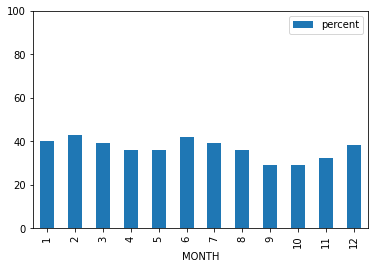

In [102]:
q143a = flightsDf.groupBy("MONTH").agg(F.sum(col("binaryArrDelay")).alias("sum"), F.count(col("MONTH")).alias("total"))\
.withColumn("percent", F.round((col("sum")/col("total"))*100)).orderBy("MONTH").toPandas()

q143a.plot.bar("MONTH", "percent", ylim = [0,100])

**Part B**

<AxesSubplot:xlabel='DAY_OF_WEEK'>

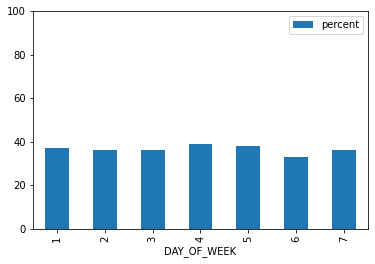

In [104]:
q143b = flightsDf.groupBy("DAY_OF_WEEK").agg(F.sum(col("binaryArrDelay")).alias("sum"), F.count(col("DAY_OF_WEEK")).alias("total"))\
.withColumn("percent", F.round((col("sum")/col("total"))*100)).orderBy("DAY_OF_WEEK").toPandas()

q143b.plot.bar("DAY_OF_WEEK", "percent", ylim = [0,100])

**Part C**

<AxesSubplot:xlabel='AIRLINE'>

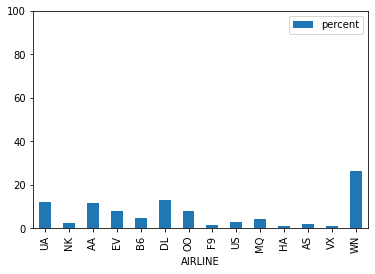

In [135]:
q143c = flightsDf.groupBy("AIRLINE").agg(F.sum(col("binaryDeptDelay")).alias("sum"))
summed = sum([x["sum"] for x in q143c.select("sum").collect()])
q143c = q143c.withColumn("percent", F.round((col("sum")/summed)*100, 1)).toPandas()

q143c.plot.bar("AIRLINE", "percent", ylim = [0,100])

# 2. Feature extraction and ML Training

## Discuss the feature selection and prepare the feature columns

We shall go through each columns one by one

**YEAR**

We can see from section 1.4.2 that there are only one single value within this database for `YEAR`, thus we can omit that as all data will have the same value. This means that this value won't impact towards our result.

**MONTH**

In [114]:
flightsDf.columns

['YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'FLIGHT_NUMBER',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'ARRIVAL_DELAY',
 'DIVERTED',
 'CANCELLED',
 'binaryArrDelay',
 'binaryDeptDelay',
 'multiClassArrDelay',
 'multiCassDeptDelay']

In [19]:
a = flightsDf.toPandas()

In [23]:
a["ARRIVAL_DELAY"] = a.ARRIVAL_DELAY.astype('category')

In [89]:
a.FLIGHT_NUMBER.value_counts()

469     397
326     353
327     353
223     348
520     342
       ... 
6856      1
5993      1
6560      1
6745      1
5949      1
Name: FLIGHT_NUMBER, Length: 6691, dtype: int64

In [90]:
flightsDf.count()

571729

In [46]:
sorted(list(set((2,7,1,3,4,5,7,7,8))))[0]

1